# CIFAR-10 Classification using fully connected neural networks

می‌خواهیم چهار دسته اول دیتاست را با استفاده از شبکه عصبی آموزش دهیم. شبکه عصبی مورد نظر در لایه ورودی ۱۰۲۴ نورون دارد. دو لایه نهان هر کدام با ۱۶ نورون و لایه خروجی ۴ نورون دارد

ابتدا دیتاست گفته شده را دانلود می‌کنیم

In [31]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 131MB/s] 


پکیج‌های مورد نیاز را اضافه می‌کنیم

In [32]:
import math
from matplotlib import pyplot as plt
import numpy as np
import random
import pickle
from statistics import mean
import os
import matplotlib.image as mpimg
import time

برای فهم بهتر محتوای دیتاست، ده تصویر از هر کدام از کلاس‌های هر دو فولدر آموزش و تست چاپ می‌کنیم.



folder: test


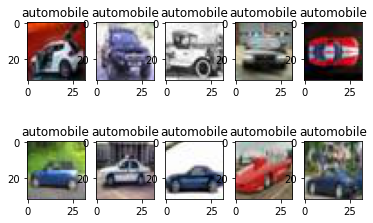

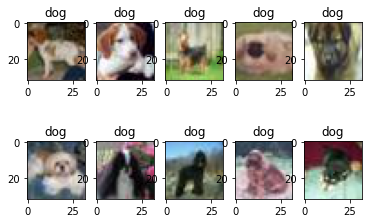

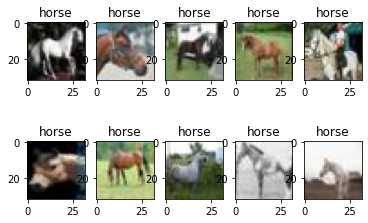

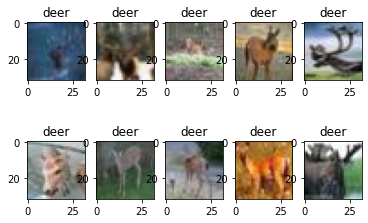

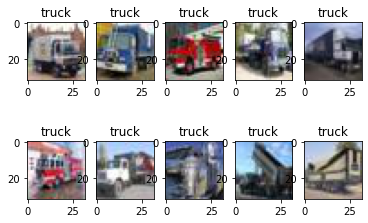

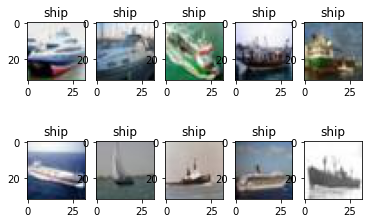

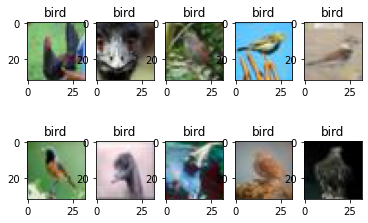

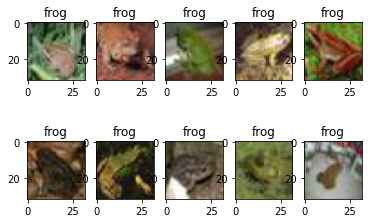

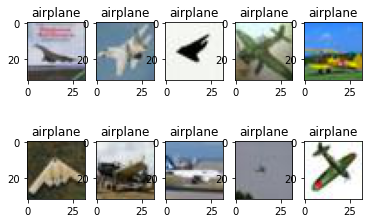

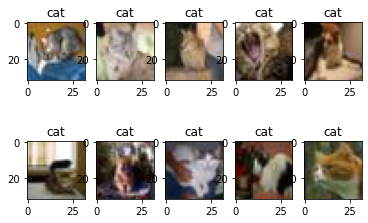

folder: train


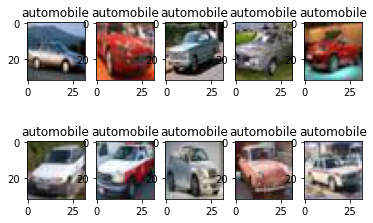

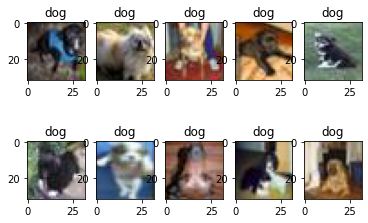

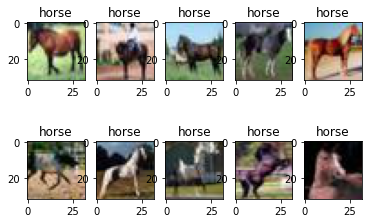

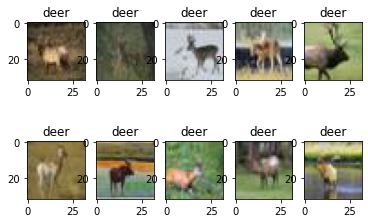

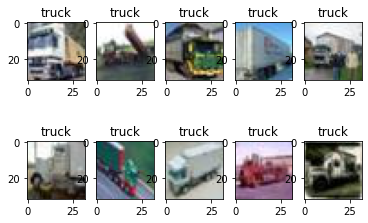

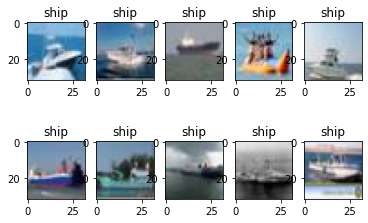

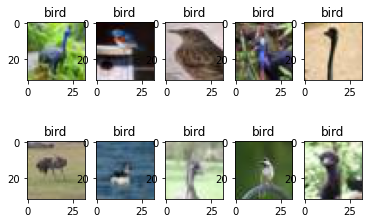

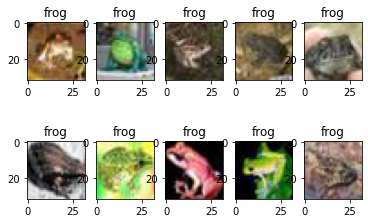

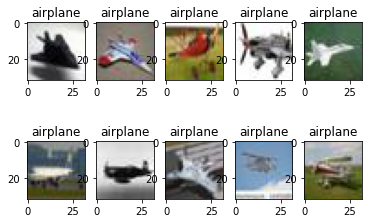

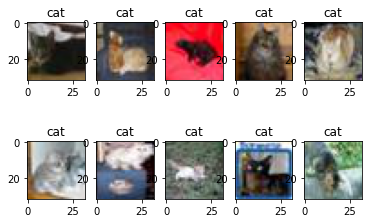

In [33]:
dir = "/content/CIFAR10/"
test = []
for folder in os.listdir(dir):
  print("folder:", folder)
  for i in os.listdir(os.path.join(dir, folder)):
    label = i
    for x in range(0, 10):
      image_file = os.path.join(dir, folder, i, "000" + str(x) + ".jpg")
      plt.subplot(2, 5, x+1)
      img = mpimg.imread(image_file)
      imgplot = plt.imshow(img)
      plt.title(i)
    plt.show()


این تابع برای ساختن آرایه برچسب‌ها استفاده می‌شود. در آرایه لیبل‌ها هر سطر مربوط به یک تصویر و هر ستون مربوط به یک دسته از اشیاست؛ ستون اول هواپیما، ستون دوم ماشین، ستون سوم پرنده و ستون چهارم گربه. از آنجا که فقط ۴ دسته اول دیتاست را بررسی می‌کنیم، ۴ نوع خروجی برای تابع در نظر می‌گیریم. اگر تصویر مورد نظر از گروه هواپیما باشد، در آرایه برچسب‌ها باید اندیس صفر آن یک و بقیه اندیس ها صفر باشد، به شکل [1,0,0,0]. اگر تصویر ماشین باشد، سطر مربوط به آن تصویر در آرایه لیبل‌ها باید به صورت [0,1,0,0] باشد و به همین ترتیب برای دیگر اشیاء

In [34]:
def find_label(class_name):
  if class_name == "airplane":
    return [1, 0, 0, 0]
  elif class_name == "automobile":
    return [0, 1, 0, 0]
  elif class_name == "bird":
    return [0, 0, 1, 0]
  elif class_name == "cat":
    return [0, 0, 0, 1]

می‌خواهیم تصاویر ۴ دسته اول از فولدر آموزش و تست‌ را در آرایه ریخته و لیبل متناظر با هر تصویر را نیز ذخیره کنیم. برای این کار نیاز به ۴ لیست داریم. یک لیست برای کل دیتای آموزش، یک لیست برای کل دیتای تست، یک لیست برای لیبل‌های دیتای آموزش و یک لیست برای لیبل‌های دیتای تست. 

In [35]:
test_data = [] 
train_data = []
test_label = []
train_label = []

وارد هر کدام از فولدهای آموزش و تست شده، وارد فولدرهای کلاس‌های مورد نظر می‌شویم و هر تصویر را با دستور

```
matplotlib.image.imread()
```
به شکل یک آرایه می‌خوانیم و به آرایه کل دیتاهای مربوطه اضافه می‌کنیم. لیبل هر عکس را نیز با توجه به اسم فولدری که در آن هستیم و با استفاده از تابعی که قبل‌تر توضیح دادیم تولید کرده و به لیست کل لیبل‌ها اضافه می‌کنیم. 
در نهایت لیست‌ها را به آرایه تبدیل می‌کنیم. 

از آنجا که در فولدر آموزش، برای هر دسته بندی ۵۰۰۰ عکس موجود است و ما ۴ دسته را پردازش کرده‌ایم، لیست دیتای آموزش (20000,32,32,32,3) است که ۳۲ اندازه طول و عرض هر عکس و ۳ به خاطر سه کانال رنگی قرمز و سبز و آبی هر عکس است. سایز آرایه  لیبل‌های مربوط به دیتای آموزش (20000,4) است چون در مجموع ۲۰۰۰۰ تصویر از ۴ دسته بندی ذخیره کرده‌ایم.

در فولدر تست برای هر دسته بندی ۱۰۰۰ عکس وجود دارد پس اندازه آرایه دیتای تست برابر (4000,32,32,3) است و سایز آرایه لیبل‌های متناظر با تصاویر تست نیز (4000,4) می‌باشد

In [36]:
dir = "/content/CIFAR10/"
classes = ["airplane", "automobile", "bird", "cat"]

for folder in os.listdir(dir):
  for class_name in classes:
    images_files = os.listdir(os.path.join(dir, folder, class_name))
    for image in images_files:
      img = mpimg.imread(os.path.join(os.path.join(dir, folder, class_name, image)))
      image_array = np.asarray(img)
      if folder == "train":
        train_data.append(image_array)
        train_label.append(find_label(class_name))
      if folder == "test":
        test_data.append(image_array)
        test_label.append(find_label(class_name))
train_data = np.array(train_data)    
train_label = np.array(train_label) 
test_data = np.array(test_data)      
test_label = np.array(test_label)
print("train:")   
print(train_data.shape)   
print(train_label.shape) 
print("test")
print(test_data.shape)   
print(test_label.shape)   


train:
(20000, 32, 32, 3)
(20000, 4)
test
(4000, 32, 32, 3)
(4000, 4)


برای کاهش پیچیدگی محاسبات، تصاویر را خاکستری می‌کنیم. قبلا که تصاویر رنگی بود، سه کانال رنگی داشتیم. بعد از خاکستری کردن، چهارمین اندیس آرایه داده‌ها که نشان دهنده تعداد کانال‌های رنگی بود و مقدار سه داشت، از بین می‌رود چون تنها یک رنگ داریم. 

In [37]:
def rgb2gray(rgb):
 r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
 gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
 return gray

train_gray = rgb2gray(train_data)
test_gray = rgb2gray(test_data)
print(train_gray.shape)
print(test_gray.shape)

(20000, 32, 32)
(4000, 32, 32)


برای افزایش سرعت محاسبات و جلوگیری از زیاده شدن اندازه گرادیان، مقادیر را با تقسیم کردن بر ۲۵۵ نرمال می‌کنیم.

In [38]:
train_gray_normalized = np.divide(train_gray, 255)
test_gray_normalized = np.divide(test_gray, 255)

چون در لایه ورودی ۱۰۲۴ نورون داریم، ابعاد ماتریس دیتا را به گونه‌ای تغییر می‌دهیم تا ابعاد ماتریس به شکل (1024,تعداد سمپل‌ها) باشد. 

In [39]:
train_data_reshaped = train_gray_normalized.reshape(-1, 1024)
test_data_reshaped = test_gray_normalized.reshape(-1, 1024)

print(train_data_reshaped.shape)
print(test_data_reshaped.shape)

(20000, 1024)
(4000, 1024)


از آنجایی که آموزش با نظارت است و لیبل هر تصویر را می‌دانیم، تصاویر را به گونه‌ای ذخیره می‌کنیم تا همراه با لیبلشان باشند. تابع زیر هر تصویر را به همراه لیبل متناظرش در یک لیست وارد می‌کند. یک لیست برای دیتای آموزش و یک لیست برای دیتای تست در نظر می‌گیریم به گونه‌ای که در هر کدام، تصاویر به همراه لیبل ذخیره شده اند. هر عضو از این لیست، در درایه صفرم دیتای خود عکس و در درایه یکم لیبل عکس را دارد

In [40]:
def join_data_label(data, label):
  data_label_set = []
  for i in range(len(data)):
    data_label_set.append((data[i].reshape(1024,1), label[i].reshape(4,1)))
  data_label_set = np.array(data_label_set, dtype=object)
  return data_label_set


train_set = join_data_label(train_data_reshaped, train_label)  # all train data with correspanding labels 
test_set = join_data_label(test_data_reshaped, test_label)  # all train data with correspanding labels 

دیتا را برهم می‌ریزیم

In [41]:
np.random.shuffle(train_set)
np.random.shuffle(test_set)

# Feedforward

تابع سیگموید طبق فرمول تعریف شده است. 

In [42]:
def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))
    return sig

بر اساس فرمول کلی فیدفوروارد، در هر لایه، باید ماتریس وزن‌ را در ماتریس مقدار هنورون‌های لایه قبل ضرب، و با بایاس مربوط به آن لایه جمع کرده و بعد به تابع فعالیت بدهیم که طبق دستورکار، تابع فعالیت در اینجا سیگموید است

In [43]:
def output(w, a, bias):
  z = (w @ a) + bias
  return sigmoid(z)

این تابع عملیات فیدفوروارد را انجام داده و با توجه به تعداد حدس‌های درست، دقت مدل را محاسبه می‌کند.

تابع در ورودی ماتریس دیتا را می‌گیرد که تعداد سطرهایش برابر تعداد تصاویری است که می‌خواهیم به عنوان ورودی به شبکه عصبی بدهیم و تعداد ستون‌هایش ۱۰۲۴ است. همچنین ماتریس‌های وزن‌ها و بردارهای بایاس‌های لایه‌های شبکه عصبی را نیز به عنوان ورودی می‌گیرد.

شبکه عصبی مورد نظر، در لایه ورودی ۱۰۲۴ نورون دارد. دو لایه نهان که هر کدام ۱۶ نورون و لایه خروجی نیز ۴ نورون دارد چون از ابتدا نیز میخواستیم دسته بندی را روی ۴ دسته انجام دهیم. 

در این تابع به ازای هر عکس، که ورودی شبکه عصبی است، مراحلی را طی می‌کنیم. ابتدا ابعاد ورودی را تنظیم می‌کنیم طوری که (1024,1) باشد. سپس برای لایه اول، ماتریس وزن‌های آن لایه را با ماتریس ورودی شبکه عصبی به همراه بایاس لایه اول به تابعی که قبل‌تر تعریف شد می‌دهیم. خروجی این تابع را به همراه وزن‌های لایه دوم و بایاس لایه دوم، به تابع می‌دهیم تا خروجی لایه بعدی مشخص شود. بار دیگر این کار را تکرار کرده تا خروجی لایه آخر مشخص شود. حال در لایه خروجی یک بردار (4,1) داریم که اندیسی که بیشترین مقدار را دارد، حدس مدل است. با پیدا کردن این اندیس و مقایسه آن با لیبل تصویر که نشان می‌دهد تصویر واقعا چه بود، دقت مدل را می‌سنجیم. تعداد حدس‌های درست تقسیم بر کل حدس‌ها دقت مدل است

In [44]:
def feedforward(dataset, w1, w2, w3, b1, b2, b3):
  correct_guesses = 0
  for idx , row in enumerate(dataset):
    data = row[0]  # each row contains image data and it's label. 0 index is the matrix (1024, 1) of image and 1 index is (4,1) label
    a1 = output(w1, data, b1)
    a2 = output(w2, a1, b2)
    a3 = output(w3, a2, b3)

    label_predicted = np.argmax(a3, axis=0)
    
    real_label = np.argmax(row[1], axis=0)

    if label_predicted[0] == real_label[0]:
      correct_guesses += 1
  
  accuracy = (correct_guesses / len(dataset)) * 100
  return accuracy

بین هر دو لایه، یک ماتریس وزن در نظر می‌گیریم که تعداد سطرهای آن برابر تعداد نورون‌های لایه بعدی و تعداد ستون‌هایش برابر تعداد نورون‌های لایه فعلی است. از آنجا که ۴ لایه داریم که در لایه اول ۱۰۲۴ نورون، دو لایه میانی هر کدام ۱۶ نورون و لایه آخر ۴ نورون دارد، ماتریس‌های وزن به صورت زیر در می‌آید. ماتریس‌های وزن‌ها را با مقادیر رندوم پر می‌کنیم.

بین هر دو لایه نیز یک بردار بایاس در نظر می‌گیریم که تعداد سطرهایش به اندازه تعداد نورون‌های لایه بعدی و تعداد ستون‌هایش یک است و با صفر پر شده است

تابع فیدفوروارد را بر روی ماتریس‌های ایجاد شده، ران می‌کنیم. از آنجا که هنوز فرآیند یادگیری طی نشده و مقداردهی ماتریس‌های وزن‌ها تصادفی بوده، دقت زیادی از مدل مورد انتظار نیست و به طور میانگین به ۲۵ درصد نزدیک است. برای مثال در چند بار اجرا دقت به این شکل بوده: 27, 21.5, 22.5, 25

In [45]:
w1 = np.random.normal(size=(16, 1024))
w2 = np.random.normal(size=(16,16))
w3 = np.random.normal(size=(4,16))

b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((4, 1))

accuracy = feedforward(train_set[:200], w1, w2, w3, b1, b2, b3)
print("accuracy =", accuracy)

accuracy = 27.0


# Backpropagation 

این تابع عملیات بک‌پروپگیشن را انجام می‌دهد. به این صورت که از لایه خروجی به لایه اول می‌آید و به ترتیب وزن‌ها و بایاس‌ها را آپدیت می‌کند

کل داده‌هایی که می‌خواهیم مدل روی آنها آموزش ببیند به دسته‌هایی تقسیم می‌کنیم و هر بار روی داده‌های هر دسته یادگیری انجام می‌شود.

با توجه به تابع هزینه‌ی داده شده، برای هر وزن‌ها و بایاس‌های هر لایه مشتقات مربوطه را به دست آورده و ماتریس‌ها را آپدیت می‌کنیم. 

در نهایت به ازای هر ایپاک آموزش، هزینه را محاسبه می‌کنیم تا بعدا نمودار هزینه را رسم کنیم. تابع هزینه نیز به صورت زیر تعریف شده است

𝐶𝑜𝑠𝑡 = ∑ (𝑎𝑗
(𝐿) − 𝑦𝑗)
2

کد این تابع بر اساس الگوریتم زیر پیاده سازی شده است

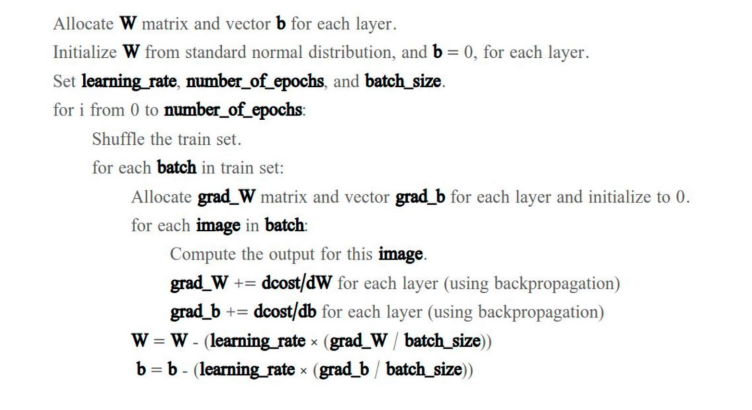

In [46]:
def backpropagation(train_set, w1, w2, w3, b1, b2, b3):
  start_time = time.time()
  
  for i in range(number_of_epochs):
    batches = [train_set[x: x+batch_size] for x in range(0, 200, batch_size)]
    for batch in batches:
      grad_w1 = np.zeros((16, 1024))
      grad_w2 = np.zeros((16, 16))
      grad_w3 = np.zeros((4, 16))

      grad_b1 = np.zeros((16,1))
      grad_b2 = np.zeros((16,1))
      grad_b3 = np.zeros((4,1))

      for image, label in batch:
        # fist we do forward propagation
        a1 = output(w1, image, b1)  # a1(16,1)
        a2 = output(w2, a1, b2)  # a2(16, 1)
        a3 = output(w3, a2, b3)  # a3(4, 1)

        # loop over indices of weight and bias matrices of output layer
        for j in range(grad_w3.shape[0]):  # 4
          for k in range(grad_w3.shape[1]):  # 16
            grad_w3[j, k] += 2 * (a3[j, 0] - label[j,0]) * (a3[j,0]) * (1 - a3[j, 0]) * a2[k,0]
        
        for j in range(grad_b3.shape[0]): # 4
          grad_b3[j, 0] += 2 * (a3[j, 0] - label[j,0]) * (a3[j,0]) * (1 - a3[j, 0])

        # hidden layer 2
        grad_a2 = np.zeros((16, 1))
        for k in range(grad_a2.shape[0]):  # 16
          for j in range(a3.shape[0]):  # 4
            grad_a2[k,0] += 2 * (a3[j, 0] - label[j, 0]) * (a3[j,0]) * (1 - a3[j, 0]) * w2[j, k]

        for k in range(grad_w2.shape[0]):
                for m in range(grad_w2.shape[1]):
                    grad_w2[k, m] += grad_a2[k, 0] * (a2[k, 0]) * (1 - a2[k, 0]) * a1[m, 0]

        for k in range(grad_b2.shape[0]):
            grad_b2[k, 0] += grad_a2[k, 0] * (a2[k, 0]) * (1 - a2[k, 0])


        # hidden layer 1
        grad_a1 = np.zeros((16,1))
        for m in range(grad_a1.shape[0]):  # 16
          for k in range(a2.shape[0]):  # 16
            grad_a1[m, 0] += grad_a2[k, 0] * (a2[k, 0]) * (1 - a2[k, 0]) * w1[k, m]
        

        for m in range(grad_w1.shape[0]):
            for v in range(grad_w1.shape[1]):
                grad_w1[m, v] += grad_a1[m, 0] * (a1[m, 0]) * (1 - a1[m, 0]) * image[v, 0]  

        for m in range(grad_b1.shape[0]):
                grad_b1[m, 0] += grad_a1[m, 0] * (a1[m, 0]) * (1 - a1[m, 0])



      w1 -= learning_rate * (grad_w1 / batch_size)
      w2 -= learning_rate * (grad_w2 / batch_size)
      w3 -= learning_rate * (grad_w3 / batch_size)

      b1 -= learning_rate * (grad_b1 / batch_size)
      b2 -= learning_rate * (grad_b2 / batch_size)
      b3 -= learning_rate * (grad_b3 / batch_size)


    # calculate cost 
    cost = 0
    for data in train_set[:200]:
      a1 = output(w1, data[0], b1)
      a2 = output(w2, a1, b2)
      a3 = output(w3, a2, b3)

      for j in range(4):
        cost += np.power((a3[j, 0] - data[1][j, 0]), 2)
    
    cost /= 200
    total_cost.append(cost)
  
  execution_duration = time.time() - start_time
  print("execution time = %s seconds" %"{:.2f}".format(execution_duration))
  

.هایپرپارامترها را طبق خواسته دستورکار مقدار می‌دهیم

ماتریس وزن‌ها را رندوم پر کرده و بردارهای بایاس‌ها را با صفر مقداردهی می‌کنیم. یک آرایه برای ذخیره کردن هزینه هر بار آموزش مدل ایجاد می‌کنیم تا در آخر بتوانیم نمودار هزینه را رسم کنیم


In [47]:
batch_size = 16
learning_rate = 0.3
number_of_epochs = 10

w1 = np.random.normal(size=(16, 1024))
w2 = np.random.normal(size=(16,16))
w3 = np.random.normal(size=(4,16))

b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((4, 1))

total_cost = []

تابع بک‌پروپگیشن را صدا می‌زنیم و از آنجا که زمان اجرا را برمی‌گرداند، خروجی آن را در یک متغیر ذخیره می‌کنیم. برای محاسبه دقت نیز، ماتریس‌های وزن‌ها و بایاس ها که آپدیت شده اند به تابع فیدفوروارد می‌دهیم تا دقت این وزن‌ها و بایاس‌ها را به دست بیاورد

در نهایت نمودار هزینه را رسم می‌کنیم

execution time = 94.66 seconds
accuracy = 37.5


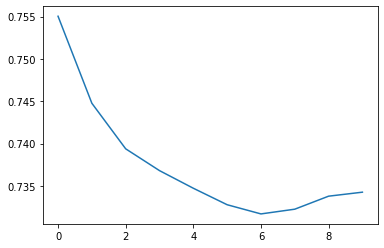

In [48]:
backpropagation(train_set, w1, w2, w3, b1, b2, b3)
accuracy = feedforward(train_set[:200], w1, w2, w3, b1, b2, b3)  # to calculate accuracy


print("accuracy =", accuracy)
plt.plot([x for x in range(number_of_epochs)], total_cost)
plt.show()

یک نمونه خروجی اجرا:

executian time: 1m 32s

accuracy: 26.5


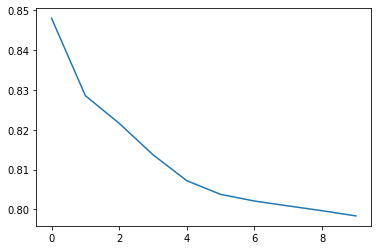

# Vectorization



برای اینکه محاسبات سریع‌تر شود، الگوریتم پیاده سازی شده در مرحله قبل را به صورتی می‌نویسیم که از عملیات ماتریسی برای محاسبات استفاده شود. از آنجا که عملیات بر روی ماتریس‌ها می‌توانند به صورت همزمان انجام شوند، سرعت اجرا را افزایش می‌دهند. الگوریتم مانند قبل است فقط به جای حلقه زدن روی همه‌ی درایه‌های ماتریس‌ها، از ضرب و جمع ماتریسی استفاده می‌کنیم

در نهایت هزینه و زمان اجرای تابع محاسبه می‌شود. از آنجا که می‌خواهیم این تابع را چندین بار اجرا کنیم، هزینه و زمان اجرا و میزان دقت را در یک لیست ذخیره و در نهایت نیز نمودار هزینه را رسم می‌کنیم

In [49]:
def vectorization(train_set, w1, w2, w3, b1, b2, b3, size_of_modeling):
  start_time = time.time()
  total_cost = []
  correct_guesses = 0  # to calculate the accuracy

  for i in range(number_of_epochs):
    batches = [train_set[x: x+batch_size] for x in range(0, size_of_modeling, batch_size)]
    for batch in batches:
      grad_w1 = np.zeros((16, 1024))
      grad_w2 = np.zeros((16, 16))
      grad_w3 = np.zeros((4, 16))

      grad_b1 = np.zeros((16,1))
      grad_b2 = np.zeros((16,1))
      grad_b3 = np.zeros((4,1))

      for image, label in batch:
        # fist we do forward propagation
        a1 = output(w1, image, b1)  # a1(16,1)
        a2 = output(w2, a1, b2)  # a2(16, 1)
        a3 = output(w3, a2, b3)  # a3(4, 1)

        # computation of output layer
        grad_w3 += 2 * (a3 - label) * a3 * (1 - a3) @ np.transpose(a2)
        grad_b3 += 2 * (a3 - label) * a3 * (1 - a3)

        # hidden layer 2
        grad_a2 = np.zeros((16, 1))
        grad_a2 += np.transpose(w3) @ (2 * (a3 - label) * a3 * (1 - a3))
        grad_w2 +=  grad_a2 * a2 * (1 - a2) @ np.transpose(a1)
        grad_b2 += grad_a2 * a2 * (1 - a2)

        # hidden layer 1
        grad_a1 = np.zeros((16,1))
        grad_a1 += np.transpose(w2) @ (grad_a2 * a2 * (1 - a2))
        grad_w1 += grad_a1 * a1 * (1 - a1) @ np.transpose(image)
        grad_b1 += grad_a1 * a1 * (1 - a1)
      
      w1 -= learning_rate * (grad_w1 / batch_size)
      w2 -= learning_rate * (grad_w2 / batch_size)
      w3 -= learning_rate * (grad_w3 / batch_size)

      b1 -= learning_rate * (grad_b1 / batch_size)
      b2 -= learning_rate * (grad_b2 / batch_size)
      b3 -= learning_rate * (grad_b3 / batch_size)

    
    # calculate cost
    cost = 0
    for data in train_set[:size_of_modeling]:
      a1 = output(w1, data[0], b1)
      a2 = output(w2, a1, b2)
      a3 = output(w3, a2, b3)
      
      # cost
      for j in range(4):
        cost += np.power((a3[j, 0] - data[1][j, 0]), 2)
    
    cost /= size_of_modeling
    total_cost.append(cost)

  execution_duration = time.time() - start_time
  execution_times.append(execution_duration)
  print("execution time = %s seconds" %"{:.2f}".format(execution_duration))

  accuracy = feedforward(train_set[:size_of_modeling], w1, w2, w3, b1, b2, b3)  # to calculate accuracy
  total_accuracy.append(accuracy)
  print("accuracy =", accuracy)


  plt.plot([x for x in range(number_of_epochs)], total_cost)
  plt.ylabel("cost")
  plt.xlabel("epoch")

  

هایپرپارامترها و متغیرهای اولیه را مقداردهی می‌کنیم. طبق خواسته دستورکار، ده بار تابع وکتوریزیشن صدا زده می‌شود تا دقت و هزینه و زمان اجرا به طور میانگین در ده بار اجرا محاسبه شود. لازم است قبل از هر بار اجرا ماتریس وزن‌ها و بایاس‌ها مقداردهی اولیه بشوند تا جواب محاسبات صحیح باشد. 

in 10 executions of vectorization:
1 :
execution time = 1.44 seconds
accuracy = 38.0
2 :
execution time = 1.46 seconds
accuracy = 45.0
3 :
execution time = 1.43 seconds
accuracy = 42.5
4 :
execution time = 1.44 seconds
accuracy = 46.0
5 :
execution time = 1.40 seconds
accuracy = 46.5
6 :
execution time = 1.41 seconds
accuracy = 48.5
7 :
execution time = 1.46 seconds
accuracy = 43.0
8 :
execution time = 1.38 seconds
accuracy = 49.5
9 :
execution time = 1.42 seconds
accuracy = 45.5
10 :
execution time = 1.40 seconds
accuracy = 48.5

average accuracy = 45.3
average cost = 73.76
average execution time = 1.42


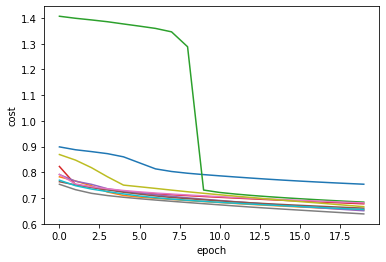

In [50]:
batch_size = 16
learning_rate = 0.3
number_of_epochs = 20


total_accuracy = []
execution_times = []

number_of_execution = 10

print("in %s executions of vectorization:" % number_of_execution)
for i in range(number_of_execution):
  w1 = np.random.normal(size=(16, 1024))
  w2 = np.random.normal(size=(16,16))
  w3 = np.random.normal(size=(4,16))

  b1 = np.zeros((16, 1))
  b2 = np.zeros((16, 1))
  b3 = np.zeros((4, 1))
  print(i+1,":") 
  vectorization(train_set, w1, w2, w3, b1, b2, b3, 200)


avg_accuracy = np.sum(total_accuracy) / len(total_accuracy)

print("\naverage accuracy =", avg_accuracy)
print("average cost = %s" %"{:.2f}".format((np.sum(total_cost) / len(total_cost) * 100)))
print("average execution time = %s" %"{:.2f}".format(np.sum(execution_times) / len(execution_times)))


خروجی یک نمونه اجرا:

average accuracy = 43.15

average cost = 72.90

average execution time = 1.56

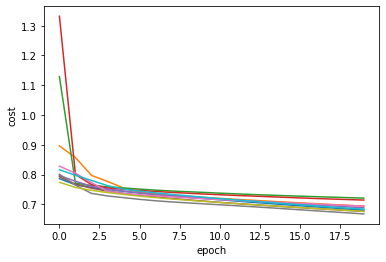

حال روی دیتای بیشتری آموزش صورت می‌گیرد. تعداد ایپاک‌ها را ۴۰ گذاشته و روی ۸۰۰۰ داده یادگیری صورت می‌گیرد. کلیات اجرا مانند بخش قبلی است و فقط تعداد داده‌های آموزش بیشتر شده است تا مدل دقیق‌تر شود

in 10 executions of vectorization on 8000 data of training data:
1 :
execution time = 109.63 seconds
accuracy = 56.06250000000001
2 :
execution time = 110.17 seconds
accuracy = 54.65
3 :
execution time = 109.77 seconds
accuracy = 53.574999999999996
4 :
execution time = 109.92 seconds
accuracy = 53.2125
5 :
execution time = 110.62 seconds
accuracy = 51.425
6 :
execution time = 110.74 seconds
accuracy = 56.074999999999996
7 :
execution time = 109.86 seconds
accuracy = 54.862500000000004
8 :
execution time = 111.02 seconds
accuracy = 57.3125
9 :
execution time = 110.93 seconds
accuracy = 55.125
10 :
execution time = 109.33 seconds
accuracy = 56.137499999999996

average accuracy = 54.84375
average cost = 73.76
average execution time = 110.20


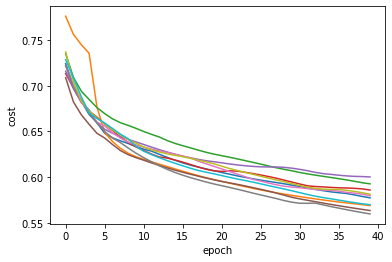

In [51]:
batch_size = 16
learning_rate = 0.3
number_of_epochs = 40

total_accuracy = []
execution_times = []

number_of_execution = 10

print("in %s executions of vectorization on 8000 data of training data:" % number_of_execution)
for i in range(number_of_execution):
  w1 = np.random.normal(size=(16, 1024))
  w2 = np.random.normal(size=(16,16))
  w3 = np.random.normal(size=(4,16))

  b1 = np.zeros((16, 1))
  b2 = np.zeros((16, 1))
  b3 = np.zeros((4, 1))
  print(i+1,":") 
  vectorization(train_set, w1, w2, w3, b1, b2, b3, 8000)


avg_accuracy = np.sum(total_accuracy) / len(total_accuracy)
print("\naverage accuracy =", avg_accuracy)
print("average cost = %s" %"{:.2f}".format((np.sum(total_cost) / len(total_cost) * 100)))
print("average execution time = %s" %"{:.2f}".format(np.sum(execution_times) / len(execution_times)))



یک نمونه خروجی:

average accuracy = 56.9

average cost = 84.01

average execution time = 125.88

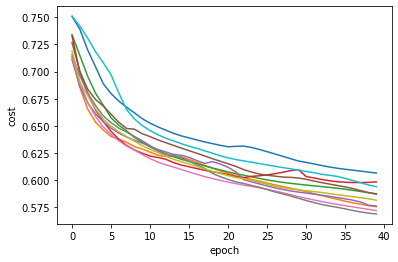

حال که تا حد خوبی آموزش روی مدل صورت گرفته است، روی ۴۰۰۰ داده تست اجرا می‌کنیم و دقت و زمان اجرا و هزینه میانگین را محاسبه و نمودار هزینه را رسم می‌کنیم

in 10 executions of vectorization on 4000 data of test data:
1 :
execution time = 54.60 seconds
accuracy = 50.949999999999996
2 :
execution time = 54.98 seconds
accuracy = 51.65
3 :
execution time = 54.76 seconds
accuracy = 49.875
4 :
execution time = 54.79 seconds
accuracy = 51.125
5 :
execution time = 54.87 seconds
accuracy = 49.925000000000004
6 :
execution time = 54.82 seconds
accuracy = 50.74999999999999
7 :
execution time = 54.76 seconds
accuracy = 53.075
8 :
execution time = 54.92 seconds
accuracy = 52.2
9 :
execution time = 54.76 seconds
accuracy = 53.27499999999999
10 :
execution time = 54.26 seconds
accuracy = 52.25

average accuracy = 51.50749999999999
average cost = 73.76
average execution time = 54.75


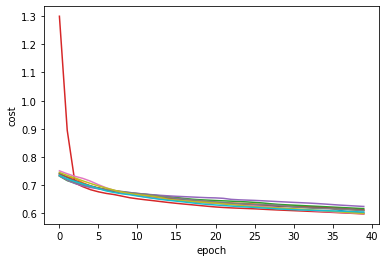

In [52]:
batch_size = 16
learning_rate = 0.3
number_of_epochs = 40

total_accuracy = []
execution_times = []

number_of_execution = 10

print("in %s executions of vectorization on 4000 data of test data:" % number_of_execution)
for i in range(number_of_execution):
  w1 = np.random.normal(size=(16, 1024))
  w2 = np.random.normal(size=(16,16))
  w3 = np.random.normal(size=(4,16))

  b1 = np.zeros((16, 1))
  b2 = np.zeros((16, 1))
  b3 = np.zeros((4, 1))
  print(i+1,":") 
  vectorization(test_set, w1, w2, w3, b1, b2, b3, 4000)


avg_accuracy = np.sum(total_accuracy) / len(total_accuracy)
print("\naverage accuracy =", avg_accuracy)
print("average cost = %s" %"{:.2f}".format((np.sum(total_cost) / len(total_cost) * 100)))
print("average execution time = %s" %"{:.2f}".format(np.sum(execution_times) / len(execution_times)))



خروجی یک نمونه ران شده:

average accuracy = 52.11

average cost = 83.55

average execution time = 55.54

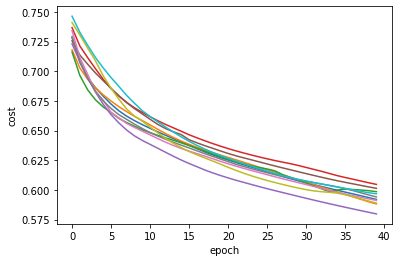

روند نزولی نمودارها همان چیزی است که انتظار داشتیم شبکه عصبی با یادگیری بیشتر نتیجه دهد